In [ ]:
# install torchio and shap dependecies
!pip install --quiet --upgrade torchio
!pip install shap

In [ ]:
import os
try:
  os.makedirs('CT_Onco')
  os.chdir('CT_Onco')
except Exception as e:
  print(e)

[Errno 17] File exists: 'CT_Onco'


In [ ]:
!tar -xvzf XXX/CT_COVID/Medie.tar.gz

Importo tutte le librerie necessarie

In [ ]:
#CUDA_LAUNCH_BLOCKING=1
import h5py
import tempfile
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
import cv2
# librerie pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.optim import Adam
from torch.utils import data
import torch.utils.data as utils
from torch.utils.data import Dataset

from scipy import stats
import time
from google.colab import widgets
import torch.nn.init as init
import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM
import SimpleITK as sitk
import copy

In [ ]:
os.chdir('/content')
os.listdir('CT_Onco')

['Medie']

In [ ]:
# Function for visualization during training
def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_sample(sample, image_name, label_name=None):
    if label_name is not None:
        sample = copy.deepcopy(sample)
        image_tensor = sample[image_name][DATA][0]
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

In [ ]:
images_dir = 'CT_Onco/Medie/'

In [ ]:
# import dataset with tabular data and output
df_completo = pd.read_csv('drive/My Drive/CT_FINE/pz_covid_MATTEO_non_norm_2.csv')
df_completo = df_completo.replace({'ESITO': {'good': 0, 'bad': 1}})

In [ ]:
df_LDH_CT = df_completo.dropna(subset=['LDH'])

In [ ]:
df_test_finale = df_LDH_CT.sample(frac = 0.2, random_state=109364524) 

In [ ]:
df_train = df_LDH.drop(df_test_finale.index)

In [ ]:
df_train.shape

(774, 43)

In [ ]:
df_test_finale.shape

(193, 43)

In [ ]:
df_train = pd.concat([df_test_finale, df_completo]).drop_duplicates(keep = False)

In [ ]:
df_train.shape

(774, 43)

In [ ]:
df_validation = df_train.sample(frac = 0.1, random_state=203040) 

In [ ]:
# delete validation data from df_train
df_train = pd.concat([df_train, df_validation]).drop_duplicates(keep = False)

In [ ]:
df_train.shape

(774, 43)

In [ ]:
df_test = df_test_finale

In [ ]:
df_train.head()

,id_paziente,ESITO,sesso,eta,bmi,Diabete,Ipertensione,Cardiopatia,Coronaropatia,Oncologico,RDW,HCT,Hb,RBC,GranulocitiBasofiliPerc,GranulocitiEosinofiliPerc,GranulocitiNeutrofiliPerc,WBC,LinfocitiPerc,MonocitiPerc,PLT,VES,Albumina,AST,ALT,BilirubinaTot,CK,Creatinina,LDH,PCR,Urea,Potassio,Sodio,HCO3,Lac,pCO2,pO2FiO2,sO2,FCing,PASing,PADing,TCing,PT_INR
1,2000000808,1,0,76,NaN,1,1,0,0,0,13.8,38.9,12.5,3.71,0.45,0.08,67.5,4.21,26.00,5.96,250,55.0,3.2,80.0,60.0,0.3,416.0,0.87,619,94.9,33.0,4.2,142,29.0,0.9,44,170,70.1,78.0,112.0,62.0,36.5,1.05
2,2000000839,0,0,73,28.5,0,1,1,0,0,11.5,37.7,12.9,4.04,0.00,0.07,77.7,5.00,14.20,8.01,209,73.0,3.2,51.0,40.0,0.7,59.0,0.76,295,192.1,29.0,3.3,136,24.1,0.8,33,430,98.2,100.0,142.0,88.0,37.5,1.03
5,2000001823,1,0,84,23.4,0,1,1,0,0,13.3,42.7,13.8,4.53,0.00,0.14,92.2,7.96,5.94,1.73,181,44.0,2.5,37.0,7.0,0.6,28.0,1.57,496,197.9,107.0,4.2,138,24.4,2.2,37,67,91.9,90.0,133.0,81.0,36.5,1.34
7,2000006143,1,1,91,24.5,1,0,1,0,0,13.6,36.5,11.5,3.88,0.30,0.17,73.8,9.83,16.70,9.06,92,NaN,NaN,16.0,7.0,0.8,57.0,1.10,164,60.8,50.0,4.0,140,23.6,1.1,33,352,96.0,62.0,134.0,59.0,38.5,NaN
8,2000006283,0,1,78,24.2,0,0,0,0,0,11.9,37.3,12.3,4.29,0.33,0.02,88.3,9.88,8.11,3.20,193,65.0,3.0,66.0,35.0,0.7,144.0,0.89,309,207.7,67.0,4.2,139,25.5,1.0,36,302,96.8,73.0,117.0,63.0,37.4,1.14


In [ ]:
for id in df_train.id_paziente:
  for id_v in df_validation.id_paziente:
    if id == id_v:
      print(id)

In [ ]:
data_totale = os.listdir(images_dir)
data_totale_no_doppi = []
dati_no_doppi = []
for i, path in enumerate(os.listdir(images_dir)):
  dati = path.split('_')[0].split('.')[0]
  if dati not in dati_no_doppi:
    dati_no_doppi.append(dati)
    data_totale_no_doppi.append(data_totale[i])

In [ ]:
label_train = df_train.loc[df_train['id_paziente'].isin(dati_no_doppi)]
label_validation = df_validation.loc[df_validation['id_paziente'].isin(dati_no_doppi)]

In [ ]:
label_train = label_train.drop_duplicates(subset ="id_paziente") 
label_validation = label_validation.drop_duplicates(subset ="id_paziente") 
df_train.loc[df_train['id_paziente'] == int(2010036318)]

,id_paziente,ESITO,sesso,eta,bmi,Diabete,Ipertensione,Cardiopatia,Coronaropatia,Oncologico,RDW,HCT,Hb,RBC,GranulocitiBasofiliPerc,GranulocitiEosinofiliPerc,GranulocitiNeutrofiliPerc,WBC,LinfocitiPerc,MonocitiPerc,PLT,VES,Albumina,AST,ALT,BilirubinaTot,CK,Creatinina,LDH,PCR,Urea,Potassio,Sodio,HCO3,Lac,pCO2,pO2FiO2,sO2,FCing,PASing,PADing,TCing,PT_INR
382,2010036318,1,1,84,26.0,0,1,1,0,0,13.6,39.5,12.9,4.35,0.0,0.02,89.5,8.05,5.98,4.52,176,81.0,2.9,62.0,62.0,0.4,98.0,0.84,528,242.4,62.0,4.7,142,22.8,1.9,28,193,82.2,87.0,137.0,75.0,37.2,1.2


In [ ]:
esiti_training = []
esiti_validation = []

In [ ]:
gravità_train = []
id_tutti_train = []
for dati in data_totale:
  id_tutti_train.append(df_train.loc[df_train['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['id_paziente'].values)
  gravità_train.append(df_train.loc[df_train['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['ESITO'].values)

In [ ]:
gravità_validation = []
id_tutti_validation = []
for dati in data_totale:
  id_tutti_validation.append(df_validation.loc[df_validation['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['id_paziente'].values)
  gravità_validation.append(df_validation.loc[df_validation['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['ESITO'].values)

In [ ]:
grav_ok_train = []
id_ok_train = []
for idx, grav in enumerate(gravità_train):
  try:
    grav[0]
    grav_ok_train.append(grav[0])
    id_ok_train.append(id_tutti_train[idx][0])
  except Exception as e:
    print(e)

In [ ]:
grav_ok_validation = []
id_ok_validation = []
for idx, grav in enumerate(gravità_validation):
  try:
    grav[0]
    grav_ok_validation.append(grav[0])
    id_ok_validation.append(id_tutti_validation[idx][0])
  except Exception as e:
    print(e)

In [ ]:
MRI = 'Lung'
LABEL = 'label'
subjects_train = []
for idx, image_path in enumerate(os.listdir(images_dir)):
    try: 
        indexx = id_ok_train.index(int(image_path.split('.')[0]))
        if (np.isnan(grav_ok_train[indexx])) == False:
            subject_dict = {

                MRI: torchio.Image(images_dir + image_path, torchio.INTENSITY),
                'label': grav_ok_train[indexx],
                'id': image_path.split('_')[0].split('.')[0]
                
            }
            print(image_path)
            print(grav_ok_train[indexx])
            
            subject = torchio.Subject(subject_dict)
            subjects_train.append(subject)
    except Exception as e:
        print(e)
dataset_training = torchio.SubjectsDataset(subjects_train)
print('Dataset size:', len(dataset_training), 'subjects')

In [ ]:
print('Training ataset size:', len(dataset_training), 'subjects')

Training ataset size: 415 subjects


In [ ]:
MRI = 'Lung'
LABEL = 'label'
subjects_validation = []
for idx, image_path in enumerate(os.listdir(images_dir)):
    try: 
        indexx = id_ok_validation.index(int(image_path.split('.')[0].split('.')[0]))
        if (np.isnan(grav_ok_validation[indexx])) == False:
            subject_dict = {

                MRI: torchio.Image(images_dir + image_path, torchio.INTENSITY),
                'label': grav_ok_validation[indexx],
                'id': image_path.split('_')[0].split('.')[0]
                
            }
            print(image_path)
            print(grav_ok_validation[indexx])
            
            subject = torchio.Subject(subject_dict)
            subjects_validation.append(subject)
    except Exception as e:
        print(e)
dataset_validation = torchio.SubjectsDataset(subjects_validation)


In [ ]:
print('Validation dataset size:', len(dataset_validation), 'subjects')

Validation dataset size: 38 subjects


In [ ]:
# Data augmentation using TorchIO
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)
training_transform = Compose([
    RescaleIntensity((0, 1)),
    #RandomNoise(),
    #ToCanonical(),
    OneOf({
        RandomAffine(isotropic=True, scales=(0.9,0.9),degrees=10, default_pad_value='otsu', p=0.5),

        RandomElasticDeformation(num_control_points=(7, 7, 7), max_displacement=10, p=0.5),
    }),
    
    ZNormalization(masking_method=ZNormalization.mean),
])

validation_transform = Compose([
    RescaleIntensity((0, 1)),
    
    ZNormalization(masking_method=ZNormalization.mean),
])


training_subjects = subjects_train
validation_subjects = subjects_validation

training_set = torchio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform = validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 415 subjects
Validation set: 38 subjects


In [ ]:
# Counting element in class for weighted random sampler
count_train = [0] * 2
for idx, batch in enumerate(training_subjects):
  print(batch['label'])
  if (int(batch['label']) == 1):
    item = 1
  elif (int(batch['label']) == 0):
    item = 0
  count_train[item] += 1

In [ ]:
weight_per_class_train = [0.] * 2  
N_train = float(sum(count_train))                                    

In [ ]:
count_train

[278, 137]

In [ ]:
for i in range(2):                                                   
        weight_per_class_train[i] = N_train/float(count_train[i]) 
print(int(N_train))
weight_train = [0] * int(N_train)

415


In [ ]:
for idx, batch in enumerate(training_subjects):
  if (batch['label'] == 1):
    item = 1
  elif (batch['label'] == 0):
    item = 0
  weight_train[idx] = weight_per_class_train[item]

In [ ]:
weight_per_class_train

[1.4928057553956835, 3.0291970802919708]

In [ ]:
sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weight_train, int(N_train)) 

In [ ]:
# Define DataLoader
train_loader = torch.utils.data.DataLoader(training_set, batch_size=4, sampler = sampler_train, drop_last=True)      
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, drop_last=True, shuffle=True)  

In [ ]:
# Model Architecture
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.gradients = None

        self.conv1 = nn.Sequential(
        
          nn.Conv3d(1, 20, (3,3,3), bias=False),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
            )
        
        self.conv2 = nn.Sequential(
        

          nn.Conv3d(20, 40, (4,4,4), bias=False),
          # pw-linear
          nn.GroupNorm(5, 40),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        
        self.conv3 = nn.Sequential(
        
          nn.Conv3d(40, 80, (3,3,3), bias=False),
          nn.GroupNorm(10, 80),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
            )
        
        self.conv4 = nn.Sequential(
        
          nn.Conv3d(80, 160, (3,3,3), bias=False),
          nn.GroupNorm(20, 160),
          nn.ReLU(),
          
          
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        self.conv5 = nn.Sequential(
        
          nn.Conv3d(160, 320,  (4,3,3), bias=False),
          nn.GroupNorm(40, 320),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3(x)
        h = x.register_hook(self.activations_hook)
        
        x = self.conv4(x)
        
        
        x = self.conv5(x)

        
        return x

    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.encoder = Encoder()
        self.dropout = nn.Dropout(p = 0.25)
        self.convf = nn.Conv3d(320, 640, (2,2,2), bias=False, )
        self.relu = nn.ReLU()  
        self.fc1 = nn.Linear(640 * 4 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)
        self.fc4 = nn.Linear(40, 2)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(num_features=84)
        self.bn3 = nn.BatchNorm1d(num_features=40)

    def forward(self, x):
        x = self.encoder(x)
        x = self.relu((self.convf(x)))
        x = x.view(-1, 640 * 4 * 2 * 2)
        x = F.tanh(self.bn1((self.fc1(x))))
        x = self.dropout(x)
        x = F.tanh(self.bn2((self.fc2(x))))
        x = self.dropout(x)
        x = F.tanh(self.bn3((self.fc3(x))))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.softmax(x)


In [ ]:
from torchsummary import summary

In [ ]:
model = Net()
model = model

#summary(model, (1, 240, 160, 160))

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

In [ ]:
import torch.optim as optim


#optimizer = optim.Adam(model.parameters(), lr=1e-5)

# mean-squared error loss
criterion = nn.CrossEntropyLoss()

In [ ]:
from torch.autograd import Variable

x = Variable(torch.ones(2, 256, 176, 160), requires_grad=True)

**TOGLIERE IL COMMENTO AL LOAD DEL MODELLO SE LO DEVI CARICARE ALTRIMENTI SI SOVRASCRIVE**

In [ ]:
# train function. Store model pth file in GDrive
def train():
  acc_train = []
  model = torch.load('/content/drive/My Drive/ADNI/model_medie_27_decima_presa.pth')
  cfg = { 'n_epochs' : 10,
          'lr'       : 3e-5,
          'optimizer': optim.SGD}
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  acc_tot = []
  loss_tot = []

  for i in range(27, 40):
      #para_loader = pl.ParallelLoader(train_loader, [dev])

      print("Training del modello")
      model.train()  # Set model to training mode
      
      loss_list, batch_list = [], []
      total_acc = []
      total_loss = 0
      count = 0
          
      for batch_idx, batch in enumerate(tqdm(train_loader)):

          if batch_idx < len(train_loader):
              
            total = 0
            correct = 0
                
            inputs = batch['Lung'][DATA].to(dev)
            label = batch['label'].to(dev, dtype=torch.long)

            output = model(inputs)
            loss = criterion(output, label)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()
            total_acc.append(correct/4*100)
            print(output)
            print(batch['id'])
            print(label)

            print('Train - Epoch %d, Batch: %d, Loss: %f, Accuracy: %f' % (i, batch_idx,  loss.detach().cpu().item(), correct/4*100))     
            print('Total accuracy: {}'.format(np.mean(total_acc)))
            loss_list.append(loss.detach().cpu().item())
            optimizer.zero_grad()

             


            loss.backward()
            optimizer.step()

            if batch_idx%1==0:


                gradients = model.encoder.get_activations_gradient()

                # pool the gradients across the channels
                pooled_gradients_0 = torch.mean(gradients, dim=[2, 3, 4])[0]
                pooled_gradients_1 = torch.mean(gradients, dim=[2, 3, 4])[1]

                # get the activations of the last convolutional layer
                activations = model.encoder.get_activations(inputs).detach()
                # weight the channels by corresponding gradients
                for j in range(40):
                    activations[0, j, :, :, :] *= pooled_gradients_0[j]
                    activations[1, j, :, :, :] *= pooled_gradients_1[j]

                # average the channels of the activations
                heatmap = torch.mean(activations, dim=1).squeeze()

                # relu on top of the heatmap
                # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
                heatmap = np.maximum(heatmap.cpu(), 0)

                # normalize the heatmap
                heatmap_0 = heatmap[0] / torch.max(heatmap[0])
                heatmap_1 = heatmap[1] / torch.max(heatmap[1])
                heatmap_0 = cv2.resize(np.float32(heatmap_0[:, :, 5]), (160, 240))
                heatmap_0 = np.uint8(255 * heatmap_0)
                #heatmap_0 = cv2.applyColorMap(heatmap_0, cv2.COLORMAP_JET)
                
                
                heatmap_1 = cv2.resize(np.float32(heatmap_1[:, :, 5]), (160, 240))
                heatmap_1 = np.uint8(255 * heatmap_1)
                #heatmap_1 = cv2.applyColorMap(heatmap_1, cv2.COLORMAP_JET)
                
                plt.subplot(121)
                plt.imshow(heatmap_0, cmap='jet')
                plt.subplot(122)
                plt.imshow(heatmap_1, cmap='jet')

                plt.show()




                plt.subplot(121)
                plt.imshow(batch['Lung'][DATA][0][0][:,:,60].detach().cpu(), cmap='gray')
                plt.subplot(122)
                plt.imshow(batch['Lung'][DATA][1][0][:,:,60].detach().cpu(), cmap='gray')


                plt.show()

                print("LOSS MEDIO {}".format(np.mean(loss_list)))
                #torch.save(model, '/content/drive/My Drive/ADNI/model_medie_{}_undicesima_presa.pth'.format(str(i)))
              
          #total_loss += loss.detach().cpu().item()

            #torch.save(model, '/content/drive/My Drive/ADNI/model_new_medie_undicesima_presa.pth')

      
  return loss

    

In [ ]:
torch.__version__

'1.8.1+cu101'

  0%|          | 0/103 [00:00<?, ?it/s]

Training del modello


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.6388, 0.3612],
        [0.0885, 0.9115],
        [0.4140, 0.5860],
        [0.8589, 0.1411]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2000037793', '3013051159', '2004032816', '3008825560']
tensor([1, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 0, Loss: 0.553435, Accuracy: 75.000000
Total accuracy: 75.0


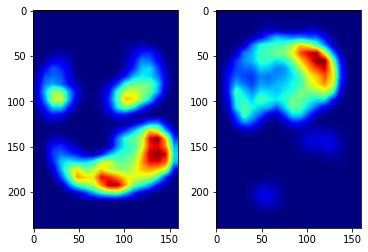

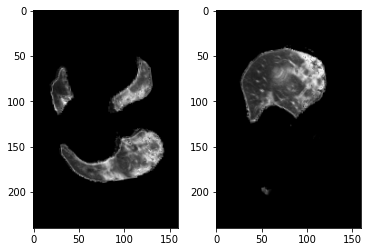

  1%|          | 1/103 [00:10<17:10, 10.10s/it]

LOSS MEDIO 0.5534346103668213


SystemError: ignored

In [ ]:
train()

In [ ]:
from sklearn import metrics

In [ ]:
# Evaluate metrics
acc_tutta = []
auc_tutta = []
loss_media = []
acc_tutta = []
for i in range(30, 40):
  model = torch.load( '/content/drive/My Drive/ADNI/model_medie_{}_decima_presa.pth'.format(str(i)))
  cfg = { 'n_epochs' : 10,
          'lr'       : 1e-4,
          'optimizer': optim.SGD}
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  acc_tot = []
  loss_tot = []

  for j in range(0, 1):
      #para_loader = pl.ParallelLoader(train_loader, [dev])

      print("Validation del modello")
      model.eval()  # Set 4odel to training mode
      
      loss_list, batch_list = [], []
      total_acc = []
      output_bc = []
      label_bc = []
      total_loss = 0
      count = 0
          
      for batch_idx, batch in enumerate(tqdm(validation_loader)):

          if batch_idx < len(validation_loader):
              
            total = 0
            correct = 0
                
            inputs = batch['Lung'][DATA].to(dev)
            label = batch['label'].to(dev, dtype=torch.long)

            output = model(inputs)
            loss = criterion(output, label)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()

            
            output_bc.append(output.data.cpu().numpy()[:,1])
            label_bc.append(label.cpu().numpy())
            total_acc.append(correct/4*100)

            print('Train - Epoch %d, Batch: %d, Loss: %f, Accuracy: %f' % (i, batch_idx,  loss.detach().cpu().item(), correct/4*100))     
            print('Total accuracy: {}'.format(np.mean(total_acc)))
            loss_list.append(loss.detach().cpu().item())
            

      
      fpr, tpr, thresholds = metrics.roc_curve(np.concatenate(label_bc).ravel(), np.concatenate(output_bc).ravel())
      print(metrics.auc(fpr, tpr))
      acc_tutta.append(np.mean(total_acc))
      loss_media.append(np.mean(loss_list))
      auc_tutta.append(np.mean(auc))



    

In [ ]:
# Print some results

In [ ]:
acc_train = [57.3232, 53.2828, 57.8282, 57.32, 63.3838, 62.3737, 63.1313, 65.1515, 69.44, 67.4242]
loss_train = [0.68, 0.6613, 0.6232, 0.62638, 0.6800, 0.6089, 0.61062, 0.6253, 0.6026, 0.598]

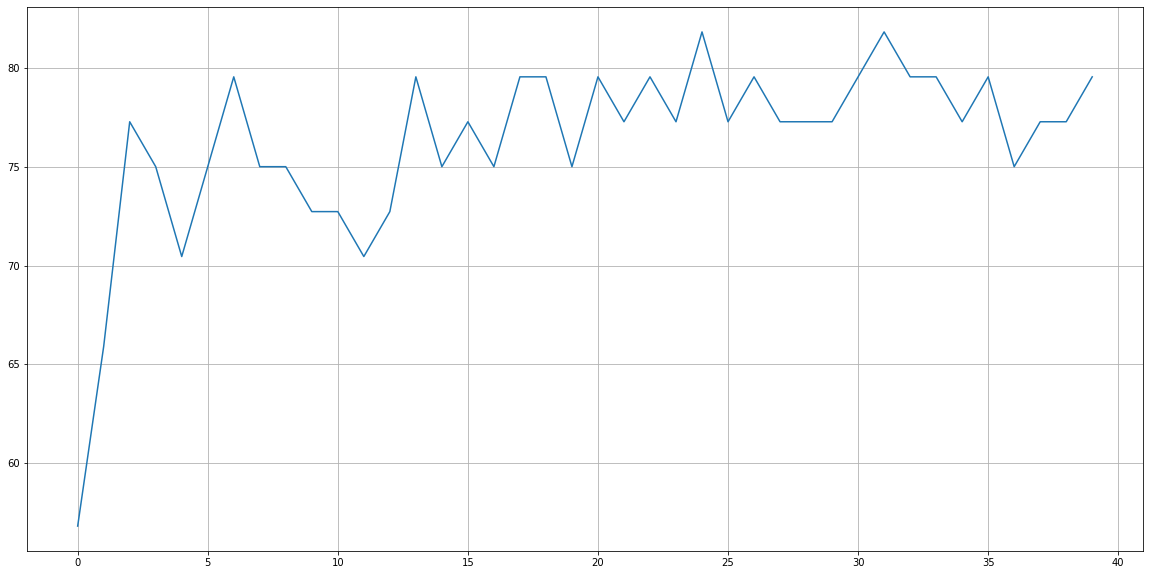

In [ ]:

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(acc_tutta)

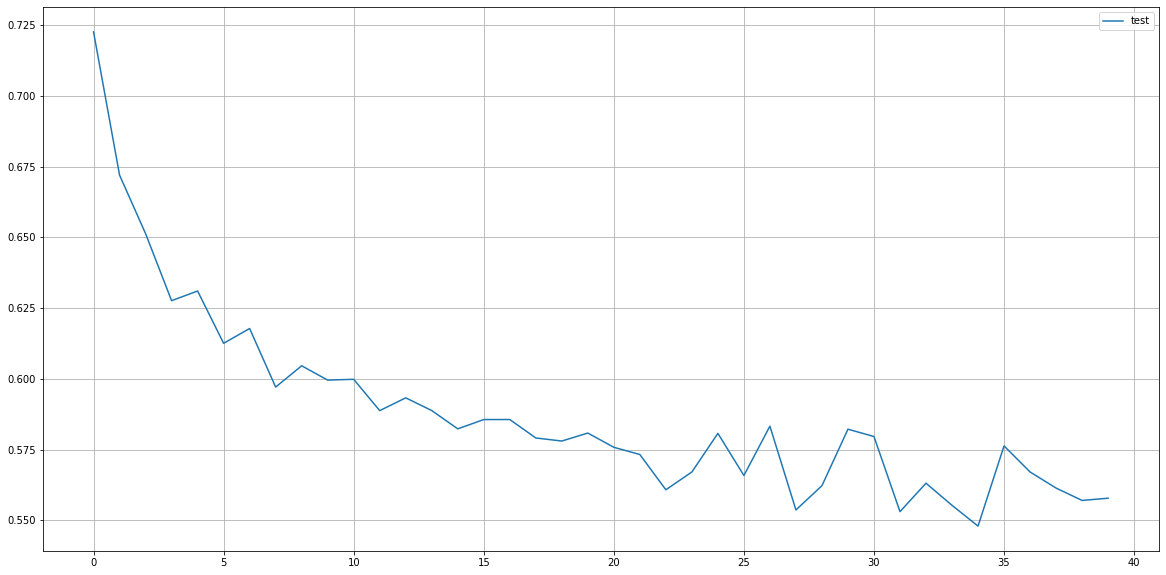

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(loss_media, label='test')
plt.legend()